In [54]:
%matplotlib inline

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_blobs, make_classification
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np

plt.style.use('ggplot')
seed = 13

Let's generate some example data for a simple classification problem.

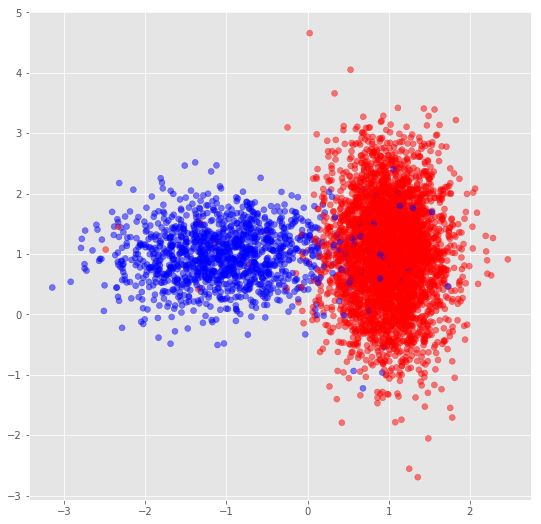

In [2]:
X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
                           n_redundant=0, n_classes=2, n_clusters_per_class=1, weights=[0.25,0.75],
                           hypercube=True, class_sep=1.0, random_state=seed)

plt.figure(figsize=(9,9))
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', alpha=0.5)
plt.show()

In [96]:
def get_ncar(y, noise_size=0.1):   
    # create an index for sampling
    idx = np.arange(y.shape[0])
    
    # pick samples to flip (no replacment!)
    idx_noise = np.random.choice(idx, size=int(noise_size*idx.shape[0]), replace=False)
    
    # flip each label to a new label
    classes = np.unique(y)
    y_ncar = y.copy()
    for i in idx_noise:
        y_ncar[i] = np.random.choice(classes[classes!=y[i]])
    return y_ncar
    

def get_nar(y, noise_size=0.1, R01=2, R10=1):
    # get scaling factors to account for class imbalance
    S0 = np.sum(y!=0)
    S1 = np.sum(y!=1)
    
    # create an index for sampling
    idx = np.arange(y.shape[0])
    
    # create normalized sampling probabilities
    p = np.ones(shape=idx.shape)
    p[y==0] = R01*S0
    p[y==1] = R10*S1
    p = normalize(p[:,np.newaxis], norm='l1', axis=0).ravel()
    
    # pick samples to flip (no replacement!)
    idx_noise = np.random.choice(idx, size=int(noise_size*idx.shape[0]), replace=False, p=p)
    
    # flip labels
    classes = np.unique(y)
    y_nar = y.copy()
    label_map = {0:1, 1:0}
    for i in idx_noise:
        sub = classes[classes!=y[i]]
        y_nar[i] = np.random.choice(sub)        
    return y_nar

def get_nnar(y, distance, alpha=10, noise_size=0.1, R01=2, R10=1):
    # get scaling factors to account for class imbalance
    S0 = np.sum(y!=0)
    S1 = np.sum(y!=1)
    
    # create an index for sampling
    idx = np.arange(y.shape[0])
    
    # create normalized sampling probabilities
    p = np.ones(shape=idx.shape)
    p[y==0] = R01*S0
    p[y==1] = R10*S1
    p *= distance**-alpha
    p = normalize(p[:,np.newaxis], norm='l1', axis=0).ravel()
    
    # pick samples to flip (no replacement!)
    idx_noise = np.random.choice(idx, size=int(noise_size*idx.shape[0]), replace=False, p=p)
    
    # flip labels
    classes = np.unique(y)
    y_nnar = y.copy()
    label_map = {0:1, 1:0}
    for i in idx_noise:
        sub = classes[classes!=y[i]]
        y_nnar[i] = np.random.choice(sub)
    return y_nnar

Get baseline performance.

In [26]:
acc = []
for i in tqdm(range(5000)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=i)
    clf = LogisticRegression().fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc.append(np.mean(y_test == y_pred))
acc = np.array(acc)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:14<00:00, 338.42it/s]


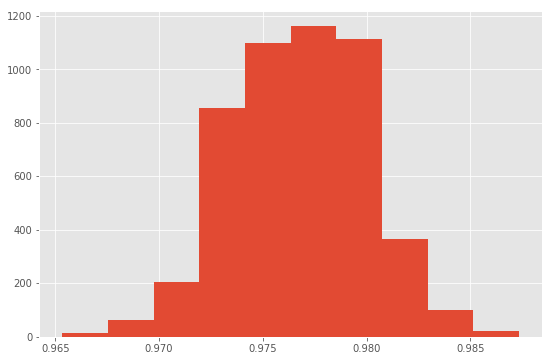

In [27]:
plt.figure(figsize=(9,6))
plt.hist(acc)
plt.show()

Label noise _completely at random_ (NCAR).

In [14]:
y_ncar = get_ncar(y, noise_size=0.1)
idx = (y != y_ncar)

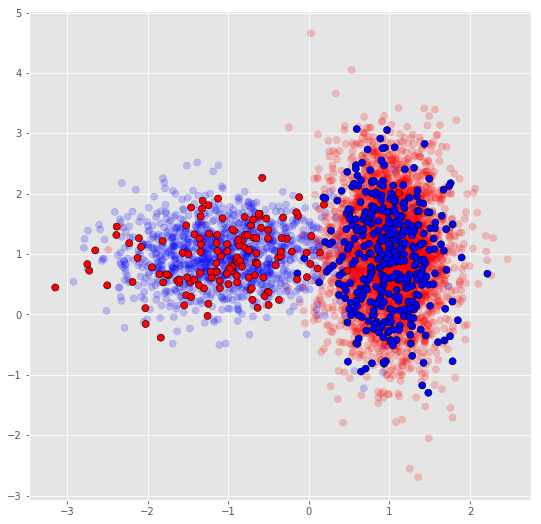

In [16]:
plt.figure(figsize=(9,9))
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', alpha=0.2, s=50)
plt.scatter(X[idx,0], X[idx,1], c=y_ncar[idx], cmap='bwr', s=50, edgecolors='black')
plt.show()

In [24]:
acc_ncar, acc_ncar_true = [], []
threshold = 0.1
for i in tqdm(range(5000)):
    # Generate random labels
    y_ncar = get_ncar(y, noise_size=0.1)
    # Random train/test split
    idx_train, idx_test = train_test_split(np.arange(y.shape[0]), test_size=0.3, stratify=y_ncar, random_state=i)
    # Train model
    clf = LogisticRegression().fit(X[idx_train], y_ncar[idx_train])
    # Generate predictions and calculate performance
    y_pred = clf.predict(X[idx_test])
    acc_ncar.append(np.mean(y_ncar[idx_test] == y_pred))
    acc_ncar_true.append(np.mean(y[idx_test] == y_pred))
acc_ncar = np.array(acc_ncar)
acc_ncar_true = np.array(acc_ncar_true)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:21<00:00, 228.07it/s]


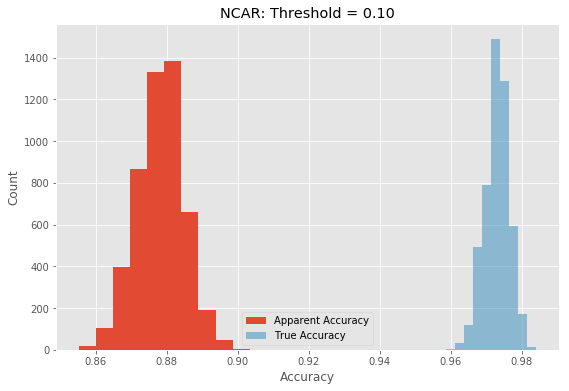

In [25]:
plt.figure(figsize=(9,6))
plt.hist(acc_ncar, label='Apparent Accuracy')
plt.hist(acc_ncar_true, label='True Accuracy', alpha=0.5)
plt.title('NCAR: Threshold = %0.2f' % threshold)
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()

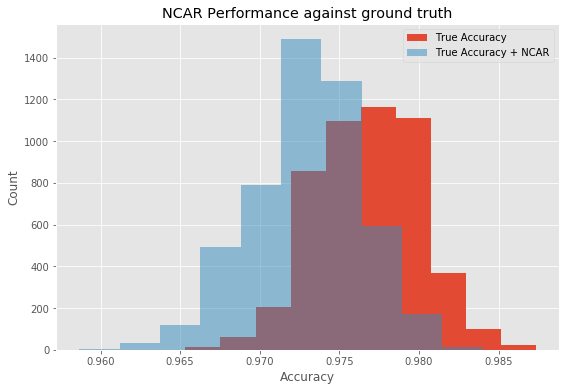

In [28]:
plt.figure(figsize=(9,6))
plt.hist(acc, label='True Accuracy')
plt.hist(acc_ncar_true, label='True Accuracy + NCAR', alpha=0.5)
plt.title('NCAR Performance against ground truth')
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()

Try different thresholds.

In [29]:
accs_ncar = []
accs_ncar_true = []
thresholds = np.arange(0, 0.21, 0.01)
for threshold in thresholds:
    print('Threshold = %0.2f' % threshold)
    acc_ncar, acc_ncar_true = [], []
    for i in tqdm(range(5000)):
        # Generate random labels
        y_ncar = get_ncar(y, noise_size=threshold)
        # Random train/test split
        idx_train, idx_test = train_test_split(np.arange(y.shape[0]), test_size=0.3, stratify=y_ncar, random_state=i)
        # Train model
        clf = LogisticRegression().fit(X[idx_train], y_ncar[idx_train])
        # Generate predictions and calculate performance
        y_pred = clf.predict(X[idx_test])
        acc_ncar.append(np.mean(y_ncar[idx_test] == y_pred))
        acc_ncar_true.append(np.mean(y[idx_test] == y_pred))
    accs_ncar.append(np.percentile(acc_ncar, [2.5, 50, 97.5]))
    accs_ncar_true.append(np.percentile(acc_ncar_true, [2.5, 50, 97.5]))
accs_ncar = np.array(accs_ncar)
accs_ncar_true = np.array(accs_ncar_true)

Threshold = 0.00


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:15<00:00, 313.84it/s]


Threshold = 0.01


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:16<00:00, 310.73it/s]


Threshold = 0.02


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:16<00:00, 297.30it/s]


Threshold = 0.03


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:17<00:00, 292.57it/s]


Threshold = 0.04


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:18<00:00, 276.44it/s]


Threshold = 0.05


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:18<00:00, 269.63it/s]


Threshold = 0.06


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:19<00:00, 257.92it/s]


Threshold = 0.07


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:20<00:00, 248.85it/s]


Threshold = 0.08


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:20<00:00, 240.62it/s]


Threshold = 0.09


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:21<00:00, 236.54it/s]


Threshold = 0.10


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:22<00:00, 223.19it/s]


Threshold = 0.11


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:22<00:00, 220.39it/s]


Threshold = 0.12


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:23<00:00, 213.71it/s]


Threshold = 0.13


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:24<00:00, 205.27it/s]


Threshold = 0.14


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:24<00:00, 200.16it/s]


Threshold = 0.15


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:25<00:00, 193.39it/s]


Threshold = 0.16


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:26<00:00, 186.05it/s]


Threshold = 0.17


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:28<00:00, 177.07it/s]


Threshold = 0.18


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:28<00:00, 174.69it/s]


Threshold = 0.19


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:28<00:00, 173.28it/s]


Threshold = 0.20


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:29<00:00, 169.43it/s]


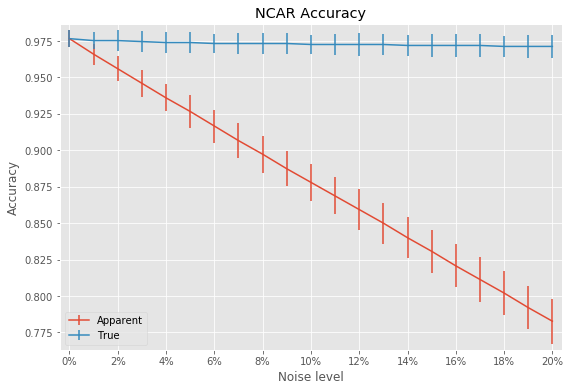

In [40]:
plt.figure(figsize=(9,6))
plt.errorbar(thresholds, accs_ncar[:,1], accs_ncar[:,1] - accs_ncar[:,0], label='Apparent')
plt.errorbar(thresholds, accs_ncar_true[:,1], accs_ncar_true[:,1] - accs_ncar_true[:,0], label='True')
plt.title('NCAR Accuracy')
plt.xlabel('Noise level')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.xticks(thresholds[::2], ['%d%%' % val for val in np.arange(0,21)[::2]])
plt.margins(0.02)
plt.show()

Label noise that occurs _at random_ (NAR).

In [56]:
y_nar = get_nar(y, noise_size=0.1)
idx = (y!=y_nar)

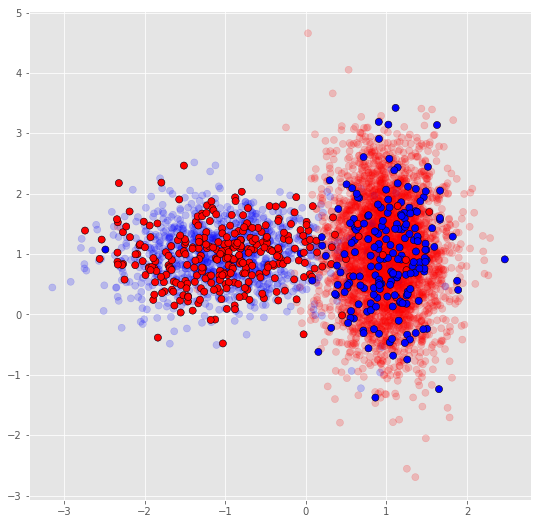

In [58]:
plt.figure(figsize=(9,9))
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', alpha=0.2, s=50)
plt.scatter(X[idx,0], X[idx,1], c=y_nar[idx], cmap='bwr', s=50, edgecolors='black')
plt.show()

In [59]:
acc_nar, acc_nar_true = [], []
threshold = 0.1
for i in tqdm(range(5000)):
    # Generate random labels
    y_nar = get_nar(y, noise_size=0.1)
    # Random train/test split
    idx_train, idx_test = train_test_split(np.arange(y.shape[0]), test_size=0.3, stratify=y_nar, random_state=i)
    # Train model
    clf = LogisticRegression().fit(X[idx_train], y_nar[idx_train])
    # Generate predictions and calculate performance
    y_pred = clf.predict(X[idx_test])
    acc_nar.append(np.mean(y_nar[idx_test] == y_pred))
    acc_nar_true.append(np.mean(y[idx_test] == y_pred))
acc_nar = np.array(acc_nar)
acc_nar_true = np.array(acc_nar_true)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:23<00:00, 208.67it/s]


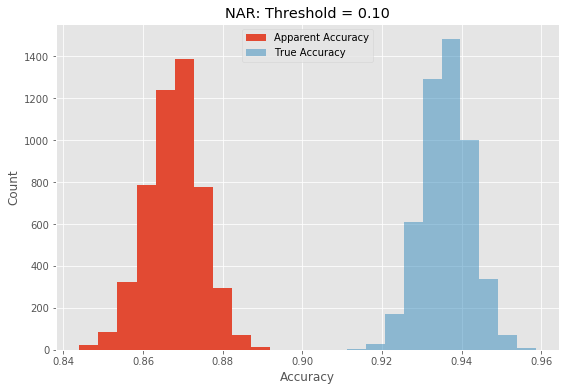

In [60]:
plt.figure(figsize=(9,6))
plt.hist(acc_nar, label='Apparent Accuracy')
plt.hist(acc_nar_true, label='True Accuracy', alpha=0.5)
plt.title('NAR: Threshold = %0.2f' % threshold)
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()

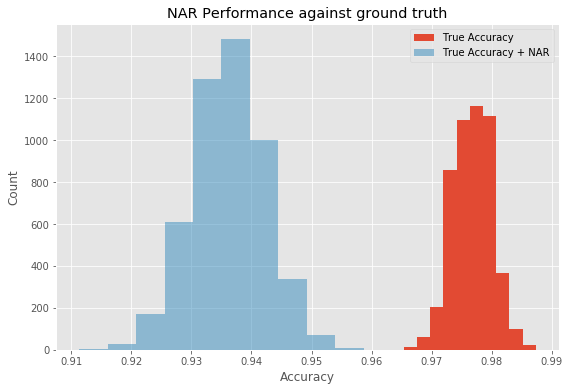

In [61]:
plt.figure(figsize=(9,6))
plt.hist(acc, label='True Accuracy')
plt.hist(acc_nar_true, label='True Accuracy + NAR', alpha=0.5)
plt.title('NAR Performance against ground truth')
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()

Try different thresholds.

In [68]:
accs_nar = []
accs_nar_true = []
thresholds = np.arange(0, 0.21, 0.01)
for threshold in thresholds:
    print('Threshold = %0.2f' % threshold)
    acc_nar, acc_nar_true = [], []
    for i in tqdm(range(5000)):
        # Generate random labels
        y_nar = get_nar(y, noise_size=threshold, R01=1, R10=1)
        # Random train/test split
        idx_train, idx_test = train_test_split(np.arange(y.shape[0]), test_size=0.3, stratify=y_nar, random_state=i)
        # Train model
        clf = LogisticRegression().fit(X[idx_train], y_nar[idx_train])
        # Generate predictions and calculate performance
        y_pred = clf.predict(X[idx_test])
        acc_nar.append(np.mean(y_nar[idx_test] == y_pred))
        acc_nar_true.append(np.mean(y[idx_test] == y_pred))
    accs_nar.append(np.percentile(acc_nar, [2.5, 50.0, 97.5]))
    accs_nar_true.append(np.percentile(acc_nar_true, [2.5, 50.0, 97.5]))
accs_nar = np.array(accs_nar)
accs_nar_true = np.array(accs_nar_true)

Threshold = 0.00


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:16<00:00, 310.17it/s]


Threshold = 0.01


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:16<00:00, 298.56it/s]


Threshold = 0.02


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:17<00:00, 287.16it/s]


Threshold = 0.03


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:17<00:00, 285.26it/s]


Threshold = 0.04


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:18<00:00, 274.32it/s]


Threshold = 0.05


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:19<00:00, 261.26it/s]


Threshold = 0.06


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:20<00:00, 248.94it/s]


Threshold = 0.07


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:20<00:00, 239.15it/s]


Threshold = 0.08


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:21<00:00, 230.80it/s]


Threshold = 0.09


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:22<00:00, 223.34it/s]


Threshold = 0.10


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:22<00:00, 218.88it/s]


Threshold = 0.11


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:23<00:00, 208.52it/s]


Threshold = 0.12


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:24<00:00, 200.31it/s]


Threshold = 0.13


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:25<00:00, 197.78it/s]


Threshold = 0.14


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:26<00:00, 191.44it/s]


Threshold = 0.15


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:27<00:00, 183.50it/s]


Threshold = 0.16


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:28<00:00, 177.33it/s]


Threshold = 0.17


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:28<00:00, 172.78it/s]


Threshold = 0.18


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:29<00:00, 167.47it/s]


Threshold = 0.19


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:31<00:00, 159.23it/s]


Threshold = 0.20


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:31<00:00, 158.48it/s]


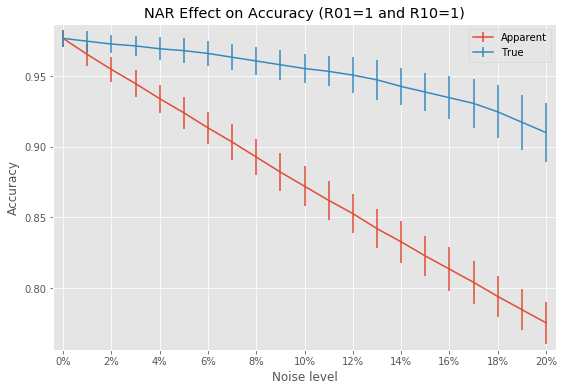

In [72]:
plt.figure(figsize=(9,6))
plt.errorbar(thresholds, accs_nar[:,1], accs_nar[:,1] - accs_nar[:,0], label='Apparent')
plt.errorbar(thresholds, accs_nar_true[:,1], accs_nar_true[:,1] - accs_nar_true[:,0], label='True')
plt.title('NAR Effect on Accuracy (R01=1 and R10=1)')
plt.xlabel('Noise level')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.xticks(thresholds[::2], ['%d%%' % val for val in np.arange(0,21)[::2]])
plt.margins(0.02)
plt.show()

In [73]:
accs_nar = []
accs_nar_true = []
thresholds = np.arange(0, 0.21, 0.01)
for threshold in thresholds:
    print('Threshold = %0.2f' % threshold)
    acc_nar, acc_nar_true = [], []
    for i in tqdm(range(5000)):
        # Generate random labels
        y_nar = get_nar(y, noise_size=threshold, R01=2, R10=1)
        # Random train/test split
        idx_train, idx_test = train_test_split(np.arange(y.shape[0]), test_size=0.3, stratify=y_nar, random_state=i)
        # Train model
        clf = LogisticRegression().fit(X[idx_train], y_nar[idx_train])
        # Generate predictions and calculate performance
        y_pred = clf.predict(X[idx_test])
        acc_nar.append(np.mean(y_nar[idx_test] == y_pred))
        acc_nar_true.append(np.mean(y[idx_test] == y_pred))
    accs_nar.append(np.percentile(acc_nar, [2.5, 50.0, 97.5]))
    accs_nar_true.append(np.percentile(acc_nar_true, [2.5, 50.0, 97.5]))
accs_nar = np.array(accs_nar)
accs_nar_true = np.array(accs_nar_true)

Threshold = 0.00


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:16<00:00, 306.41it/s]


Threshold = 0.01


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:16<00:00, 298.10it/s]


Threshold = 0.02


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:17<00:00, 286.76it/s]


Threshold = 0.03


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:17<00:00, 281.39it/s]


Threshold = 0.04


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:18<00:00, 272.09it/s]


Threshold = 0.05


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:19<00:00, 251.88it/s]


Threshold = 0.06


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:21<00:00, 230.14it/s]


Threshold = 0.07


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:24<00:00, 200.94it/s]


Threshold = 0.08


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:26<00:00, 191.96it/s]


Threshold = 0.09


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:26<00:00, 186.40it/s]


Threshold = 0.10


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:29<00:00, 170.92it/s]


Threshold = 0.11


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:29<00:00, 166.75it/s]


Threshold = 0.12


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:29<00:00, 169.74it/s]


Threshold = 0.13


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:29<00:00, 170.53it/s]


Threshold = 0.14


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:30<00:00, 162.00it/s]


Threshold = 0.15


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:30<00:00, 162.49it/s]


Threshold = 0.16


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:31<00:00, 157.00it/s]


Threshold = 0.17


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:33<00:00, 149.64it/s]


Threshold = 0.18


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:34<00:00, 145.29it/s]


Threshold = 0.19


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:34<00:00, 144.66it/s]


Threshold = 0.20


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:34<00:00, 144.23it/s]


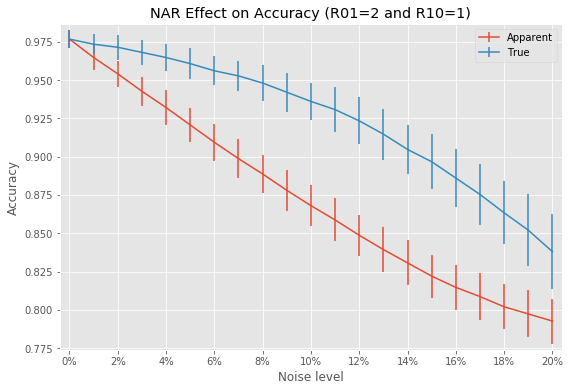

In [74]:
plt.figure(figsize=(9,6))
plt.errorbar(thresholds, accs_nar[:,1], accs_nar[:,1] - accs_nar[:,0], label='Apparent')
plt.errorbar(thresholds, accs_nar_true[:,1], accs_nar_true[:,1] - accs_nar_true[:,0], label='True')
plt.title('NAR Effect on Accuracy (R01=2 and R10=1)')
plt.xlabel('Noise level')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.xticks(thresholds[::2], ['%d%%' % val for val in np.arange(0,21)[::2]])
plt.margins(0.02)
plt.show()

In [75]:
accs_nar = []
accs_nar_true = []
thresholds = np.arange(0, 0.21, 0.01)
for threshold in thresholds:
    print('Threshold = %0.2f' % threshold)
    acc_nar, acc_nar_true = [], []
    for i in tqdm(range(5000)):
        # Generate random labels
        y_nar = get_nar(y, noise_size=threshold, R01=3, R10=1)
        # Random train/test split
        idx_train, idx_test = train_test_split(np.arange(y.shape[0]), test_size=0.3, stratify=y_nar, random_state=i)
        # Train model
        clf = LogisticRegression().fit(X[idx_train], y_nar[idx_train])
        # Generate predictions and calculate performance
        y_pred = clf.predict(X[idx_test])
        acc_nar.append(np.mean(y_nar[idx_test] == y_pred))
        acc_nar_true.append(np.mean(y[idx_test] == y_pred))
    accs_nar.append(np.percentile(acc_nar, [2.5, 50.0, 97.5]))
    accs_nar_true.append(np.percentile(acc_nar_true, [2.5, 50.0, 97.5]))
accs_nar = np.array(accs_nar)
accs_nar_true = np.array(accs_nar_true)

Threshold = 0.00


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:16<00:00, 305.02it/s]


Threshold = 0.01


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:16<00:00, 302.64it/s]


Threshold = 0.02


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:17<00:00, 287.31it/s]


Threshold = 0.03


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:17<00:00, 279.05it/s]


Threshold = 0.04


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:18<00:00, 271.72it/s]


Threshold = 0.05


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:19<00:00, 259.05it/s]


Threshold = 0.06


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:20<00:00, 247.24it/s]


Threshold = 0.07


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:21<00:00, 236.57it/s]


Threshold = 0.08


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:22<00:00, 227.24it/s]


Threshold = 0.09


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:22<00:00, 217.69it/s]


Threshold = 0.10


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:23<00:00, 210.51it/s]


Threshold = 0.11


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:24<00:00, 203.10it/s]


Threshold = 0.12


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:25<00:00, 196.39it/s]


Threshold = 0.13


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:26<00:00, 190.63it/s]


Threshold = 0.14


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:26<00:00, 185.34it/s]


Threshold = 0.15


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:27<00:00, 182.07it/s]


Threshold = 0.16


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:28<00:00, 178.30it/s]


Threshold = 0.17


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:28<00:00, 173.46it/s]


Threshold = 0.18


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:29<00:00, 166.85it/s]


Threshold = 0.19


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:30<00:00, 161.48it/s]


Threshold = 0.20


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:31<00:00, 160.17it/s]


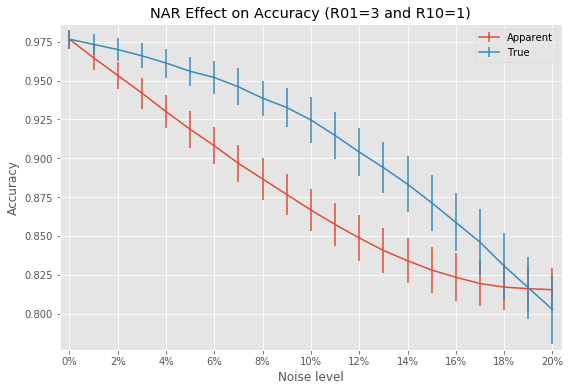

In [76]:
plt.figure(figsize=(9,6))
plt.errorbar(thresholds, accs_nar[:,1], accs_nar[:,1] - accs_nar[:,0], label='Apparent')
plt.errorbar(thresholds, accs_nar_true[:,1], accs_nar_true[:,1] - accs_nar_true[:,0], label='True')
plt.title('NAR Effect on Accuracy (R01=3 and R10=1)')
plt.xlabel('Noise level')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.xticks(thresholds[::2], ['%d%%' % val for val in np.arange(0,21)[::2]])
plt.margins(0.02)
plt.show()

Label noise _not at random_.

In [155]:
from sklearn.neighbors import KNeighborsClassifier

def get_nnar(y, distance, =10, noise_size=0.1, R01=2, R10=1):
    # get scaling factors to account for class imbalance
    S0 = np.sum(y!=0)
    S1 = np.sum(y!=1)
    
    # create an index for sampling
    idx = np.arange(y.shape[0])
    
    # create normalized sampling probabilities
    p = np.ones(shape=idx.shape)
    p[y==0] = R01*S0
    p[y==1] = R10*S1
    p *= distance**-alpha
    p = normalize(p[:,np.newaxis], norm='l1', axis=0).ravel()
    
    # pick samples to flip (no replacement!)
    idx_noise = np.random.choice(idx, size=int(noise_size*idx.shape[0]), replace=False, p=p)
    
    # flip labels
    classes = np.unique(y)
    y_nnar = y.copy()
    label_map = {0:1, 1:0}
    for i in idx_noise:
        sub = classes[classes!=y[i]]
        y_nnar[i] = np.random.choice(sub)
    return y_nnar

distance = KNeighborsClassifier(n_neighbors=10, metric='euclidean', weights='uniform').fit(X,y).predict_proba(X)[:,1]
distance

array([ 0.8,  1. ,  1. , ...,  0. ,  1. ,  1. ])

In [180]:
knn = KNeighborsClassifier(n_neighbors=20).fit(X,y)
dist = knn.predict_proba(X)[:,1]

In [189]:
[(val, np.mean((dist >= val) & (y == 0))) for val in np.unique(dist)]

[(0.0, 0.25340000000000001),
 (0.050000000000000003, 0.0596),
 (0.10000000000000001, 0.0298),
 (0.14999999999999999, 0.025999999999999999),
 (0.20000000000000001, 0.022599999999999999),
 (0.25, 0.021399999999999999),
 (0.29999999999999999, 0.020199999999999999),
 (0.34999999999999998, 0.019),
 (0.40000000000000002, 0.018200000000000001),
 (0.45000000000000001, 0.016),
 (0.5, 0.0154),
 (0.55000000000000004, 0.0154),
 (0.59999999999999998, 0.014200000000000001),
 (0.65000000000000002, 0.014),
 (0.69999999999999996, 0.013599999999999999),
 (0.75, 0.013599999999999999),
 (0.80000000000000004, 0.012999999999999999),
 (0.84999999999999998, 0.0112),
 (0.90000000000000002, 0.0086),
 (0.94999999999999996, 0.0060000000000000001),
 (1.0, 0.0)]

In [194]:
idx = (dist >= 0.1) & (y == 0)
idx.mean()

0.0298

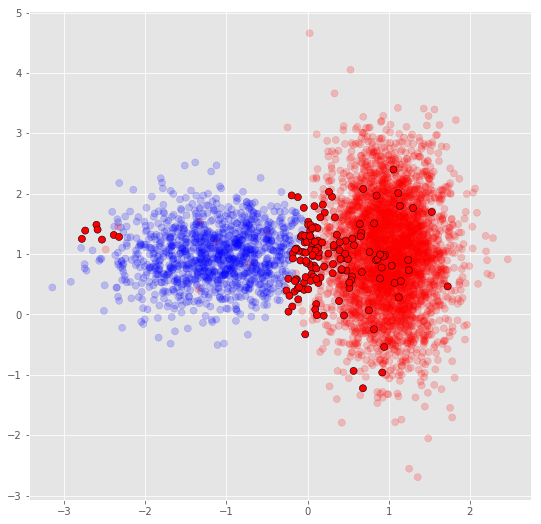

In [193]:
plt.figure(figsize=(9,9))
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', alpha=0.2, s=50)
plt.scatter(X[idx,0], X[idx,1], c=y[idx], cmap='bwr_r', s=50, edgecolors='black')
plt.show()

In [226]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(ratio='auto', n_jobs=4, return_indices=True)
tl.fit(X, y)

TomekLinks(n_jobs=4, random_state=None, ratio='auto', return_indices=True)

In [227]:
_, _, idx_tomek = tl.sample(X, y)

In [228]:
idx_tomek = np.setdiff1d(np.arange(X.shape[0]),idx_tomek)

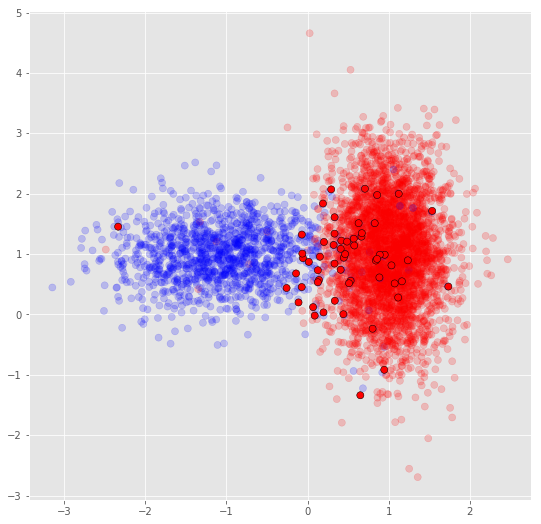

In [224]:
plt.figure(figsize=(9,9))
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', alpha=0.2, s=50)
plt.scatter(X[idx_tomek,0], X[idx_tomek,1], c=y[idx_tomek], cmap='bwr_r', s=50, edgecolors='black')
plt.show()

In [138]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=10, metric='euclidean').fit(X,y)

In [148]:
dist, ind = nn.kneighbors(X, n_neighbors=100, return_distance=True)
dist.sum(axis=1)

array([ 13.93937847,  17.28662549,  17.77084729, ...,  16.12290372,
        13.00509209,   8.35580493])

In [147]:
pd.value_counts(y[ind].mean(axis=1))

1.0    3236
0.0    1055
0.9     411
0.1     111
0.8      82
0.7      40
0.3      20
0.2      18
0.6      13
0.4       8
0.5       6
dtype: int64

([array([ 5000.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0.,     0.]),
  array([  4.96700000e+03,   2.70000000e+01,   5.00000000e+00,
           0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00]),
  array([  4.92700000e+03,   5.70000000e+01,   8.00000000e+00,
           6.00000000e+00,   1.00000000e+00,   0.00000000e+00,
           1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00]),
  array([  4.87500000e+03,   1.02000000e+02,   1.50000000e+01,
           4.00000000e+00,   2.00000000e+00,   1.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           1.00000000e+00]),
  array([  4.85500000e+03,   1.14000000e+02,   2.20000000e+01,
           5.00000000e+00,   1.00000000e+00,   2.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           1.00000000e+00]),
  array([  4.83000000e+03,  

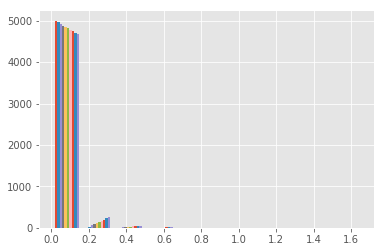

In [140]:
plt.hist(dist)

In [102]:
clf.radius

In [99]:
y_nnar = get_nnar(y, distance, alpha=2, noise_size=0.1)
idx = (y!=y_nnar)

C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\ipykernel\__main__.py:54: RuntimeWarning: divide by zero encountered in power


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

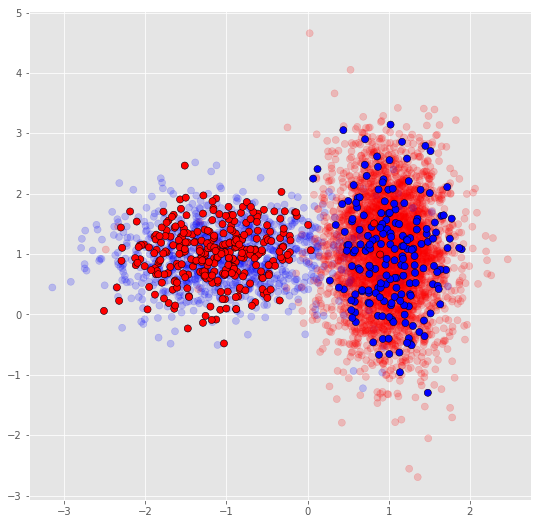

In [88]:
plt.figure(figsize=(9,9))
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', alpha=0.2, s=50)
plt.scatter(X[idx,0], X[idx,1], c=y_nnar[idx], cmap='bwr', s=50, edgecolors='black')
plt.show()